In [3]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [112]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior/"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49,2000,3,500))
responses_fft = fft(responses_split,axis=-1)
responses_fft[:,:,:,15:23] = 0
responses_fft[:,:,:,475:485] = 0
responses_filtered = ifft(responses_fft,axis=-1)
responses_filtered.shape

cluster_id = np.argmax(np.sum(responses_filtered[20,:,0,:].real, axis=1))

In [113]:
cluster_id

319

In [5]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [6]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [7]:
z=20
n_clusters = 2000
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file) #z,t
cluster_model_labels = cluster_model_labels[z,:]

In [8]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [31]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [32]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id


In [33]:
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].load_z_depth_correction()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.16 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 4.05 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 5.76 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.66 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.66 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 10.03 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.57 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.86 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.73 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.44 ms



In [29]:
fly_names

['fly_087',
 'fly_089',
 'fly_094',
 'fly_095',
 'fly_097',
 'fly_098',
 'fly_099',
 'fly_100',
 'fly_101',
 'fly_105']

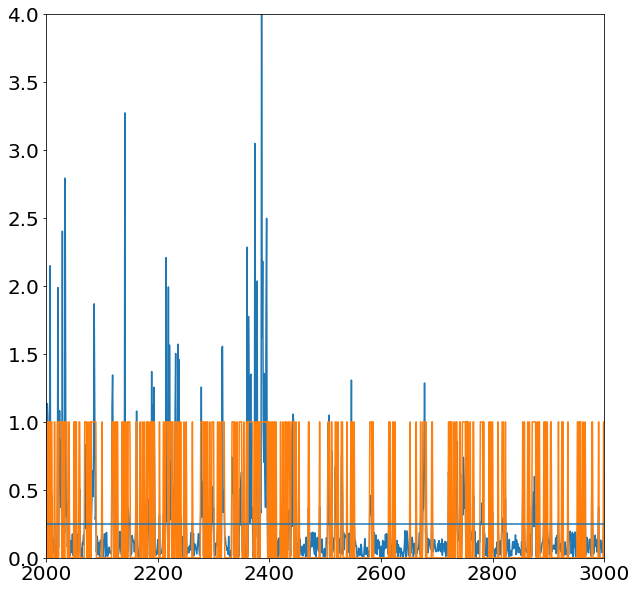

In [50]:
plt.figure(figsize=(10,10))

a = flies['fly_105'].fictrac.fictrac['YZ']

plt.plot(a)
b = np.zeros(len(a))
b[np.where(a>.2)] = 1
plt.plot(b)

plt.xlim(2000,3000)
plt.ylim(0,4)
plt.axhline(.25)

In [51]:
len(a)

3384

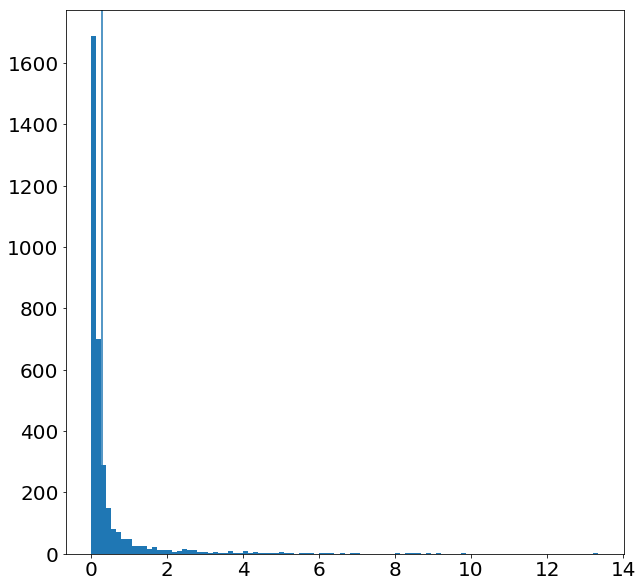

In [44]:
plt.figure(figsize=(10,10))

plt.hist(a,bins=100);
plt.axvline(.3)

In [142]:
### GET NEURAL
all_fly_neural = []
for fly in fly_names:
    signal = flies[fly].cluster_signals[cluster_id,:]
    all_fly_neural.extend(signal)
neural_signal = np.asarray(all_fly_neural)

shifts = list(range(-9,9+1,1))
toe = []
for shift in shifts:
    toe.append(np.roll(neural_signal, shift))
toe = np.asarray(toe)
#toe.shape

### GET BEHAVIOR
ypos = []
for i, fly in enumerate(fly_names):
    cluster_indicies = flies[fly].cluster_indicies[cluster_id]
    z_map = flies[fly].z_correction[:,:,z].ravel()
    original_z = int(np.median(z_map[cluster_indicies]))
    flies[fly].fictrac.interp_fictrac(original_z)
    ypos.extend(flies[fly].fictrac.fictrac['Y_pos'])
    
out = np.dot(toe, ypos)
out.shape

(19,)

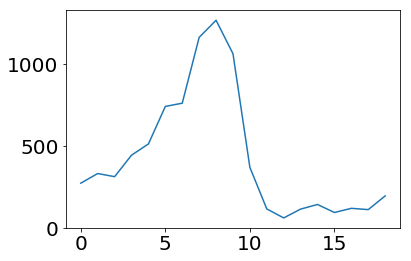

In [124]:
plt.plot(out)

In [146]:
convolved = np.convolve(ypos,out[::-1],mode='same')/len(ypos)
len(convolved)

33840

(2000, 2400)

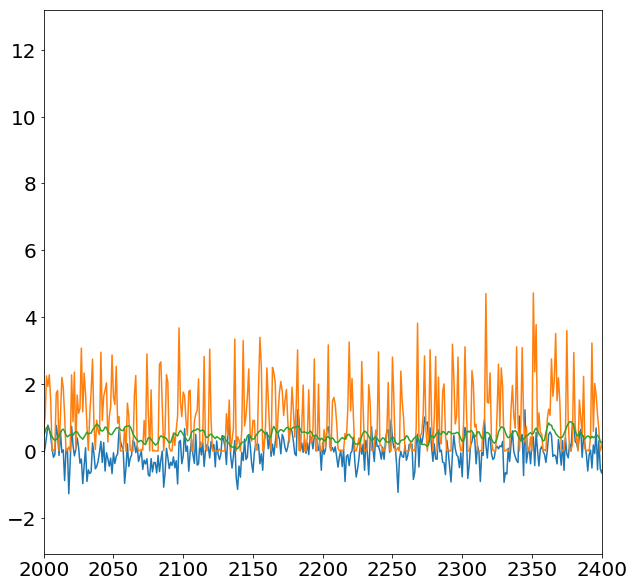

In [136]:
plt.figure(figsize=(10,10))
plt.plot(Y)
plt.plot(ypos)
plt.plot(convolved*2)
plt.xlim(2000,2400)

In [147]:
scores_all = []

scores_walking = []
scores_ypos = []
scores_zpos = []
scores_zneg = []

scores_walking_unique = []
scores_ypos_unique = []
scores_zpos_unique = []
scores_zneg_unique = []

for cluster_num in range(n_clusters):
    if cluster_num%100 == 0:
        print(cluster_num)
    ###############################################################
    ### Build Y vector for a single supervoxel (with all flies) ###
    ###############################################################
    all_fly_neural = []
    for fly in fly_names:
        signal = flies[fly].cluster_signals[cluster_num,:]
        all_fly_neural.extend(signal)
    Y = np.asarray(all_fly_neural)

    ###########################################
    ### Build the X matrix for this cluster ###
    ###########################################
    # For each fly, this cluster could have originally come from a different z-depth
    # Get correct original z-depth
    ypos = []
    zpos = []
    zneg = []
    walking = []
    for i, fly in enumerate(fly_names):
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        flies[fly].fictrac.interp_fictrac(original_z)
        ypos.extend(flies[fly].fictrac.fictrac['Y_pos'])
        zpos.extend(flies[fly].fictrac.fictrac['Z_pos'])
        zneg.extend(flies[fly].fictrac.fictrac['Z_neg'])
        
        walking_01 = np.zeros(3384)
        thresh_beh = flies[fly].fictrac.fictrac['YZ']
        walking_01[np.where(thresh_beh>.2)] = 1
        walking.extend(walking_01)

    ################
    ### CONVOLVE #########################
    ################
    ###(optional: can delete this)
    shifts = list(range(-9,9+1,1))
    toe = []
    for shift in shifts:
        toe.append(np.roll(Y, shift))
    toe = np.asarray(toe)
    ### over-writing behaviors with their convolved versions ###
    filter_ = np.dot(toe, ypos)
    ypos = np.convolve(ypos,filter_[::-1],mode='same')/len(ypos)
    
    filter_ = np.dot(toe, zpos)
    zpos = np.convolve(zpos,filter_[::-1],mode='same')/len(zpos)
    
    filter_ = np.dot(toe, zneg)
    zneg = np.convolve(zneg,filter_[::-1],mode='same')/len(zneg)
    
    filter_ = np.dot(toe, walking)
    walking = np.convolve(walking,filter_[::-1],mode='same')/len(walking)
    ########################################
    
        
    ### ALL ###
    X = np.stack((ypos, zpos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_all.append(np.sqrt(model.score(X,Y)))
       
    ### Singles ###
    X = np.reshape(walking, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_walking.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(ypos, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_ypos.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(zpos, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_zpos.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(zneg, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_zneg.append(np.sqrt(model.score(X,Y)))
        
    ### LOO ###
    X = np.stack((ypos, zpos, zneg)).T
    model = RidgeCV().fit(X,Y)
    scores_walking_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((zpos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_ypos_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_zpos_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zpos, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_zneg_unique.append(np.sqrt(model.score(X,Y)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [138]:
Y.shape

(33840,)

In [139]:
X.shape

(33858, 4)

In [150]:
scores = {'scores_all':scores_all,
         'scores_walking':scores_walking,
         'scores_ypos':scores_ypos,
         'scores_zpos':scores_zpos,
         'scores_zneg':scores_zneg,
         'scores_walking_unique':scores_walking_unique,
         'scores_ypos_unique':scores_ypos_unique,
         'scores_zpos_unique':scores_zpos_unique,
         'scores_zneg_unique':scores_zneg_unique}

import pickle

file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210125_glm/20210125_scores_convolved"

with open(file, 'wb') as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to load:
# with open(file, 'rb') as handle:
#     b = pickle.load(handle)

In [151]:
# to load:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210125_glm/20210125_scores"
with open(file, 'rb') as handle:
    scores = pickle.load(handle)

file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210125_glm/20210125_scores_convolved"
with open(file, 'rb') as handle:
    scores_conv = pickle.load(handle)

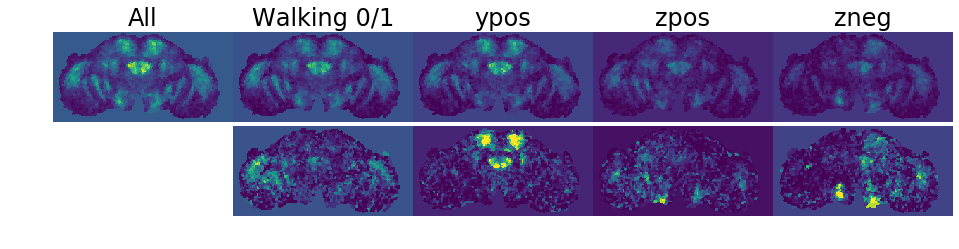

In [106]:
fig = plt.figure(figsize=(10,10))
cmap = 'viridis'
vmin=0
vmax=.2

ax = fig.add_axes([0,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num]# - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('All')

###############
### SINGLES ###
###############

ax = fig.add_axes([.25,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_walking[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('Walking 0/1')

ax = fig.add_axes([.5,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_ypos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('ypos')

ax = fig.add_axes([.75,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zpos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zpos')

ax = fig.add_axes([1,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zneg[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zneg')

##############
### UNIQUE ###
##############
vmin=0
vmax=.02

ax = fig.add_axes([.25,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_walking_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.5,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.75,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zpos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([1,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zneg_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

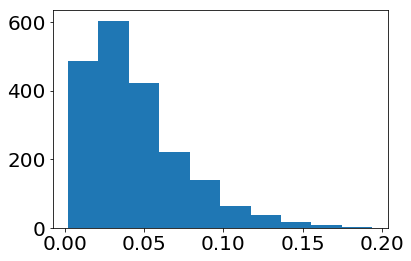

In [154]:
plt.hist(scores['scores_all']);

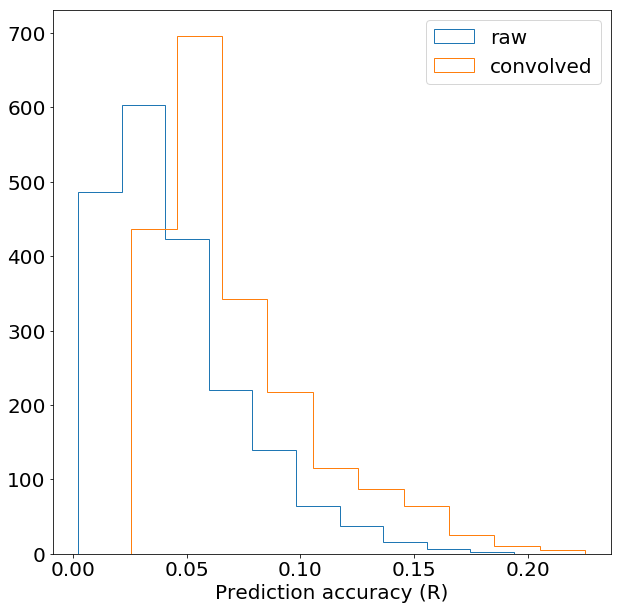

In [160]:
plt.figure(figsize=(10,10))
plt.hist(scores['scores_all'],histtype='step',label='raw');
plt.hist(scores_conv['scores_all'],histtype='step',label='convolved');
plt.legend()
plt.xlabel('Prediction accuracy (R)')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

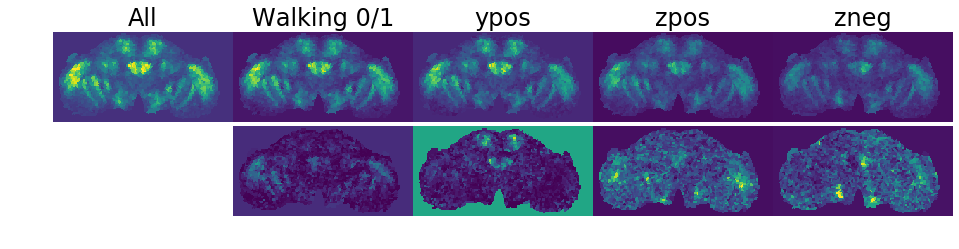

In [161]:
fig = plt.figure(figsize=(10,10))
cmap = 'viridis'
vmin=0
vmax=.2

ax = fig.add_axes([0,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num]# - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('All')

###############
### SINGLES ###
###############

ax = fig.add_axes([.25,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_walking[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('Walking 0/1')

ax = fig.add_axes([.5,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_ypos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('ypos')

ax = fig.add_axes([.75,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zpos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zpos')

ax = fig.add_axes([1,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zneg[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zneg')

##############
### UNIQUE ###
##############
vmin=0
vmax=.02

ax = fig.add_axes([.25,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_walking_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.5,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.75,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zpos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([1,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zneg_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

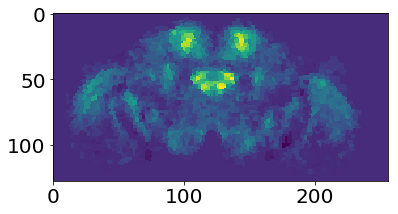

In [68]:


colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = betas_[cluster_num,0]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

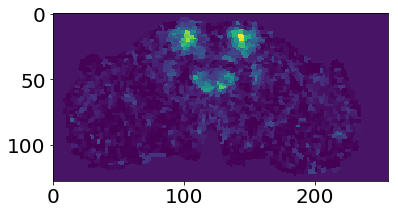

In [59]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

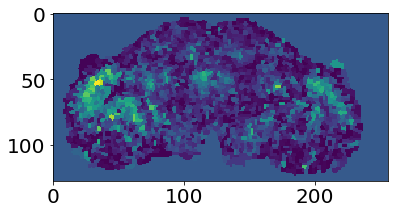

In [58]:


colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_walking_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

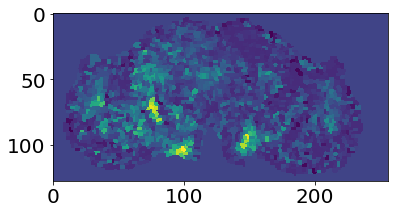

In [106]:


colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores[cluster_num] - scores_zpos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

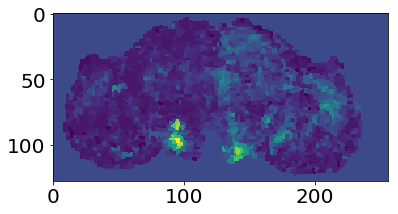

In [107]:


colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores[cluster_num] - scores_zneg_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

In [59]:
out.shape

(2000, 3)

In [53]:
scores_unique = {'Y_pos': scores_ypos_unique,
                 'Z_pos': scores_zpos_unique,
                 'Z_neg': scores_zneg_unique,
                 'walking': scores_walking_unique}

In [ ]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for j, behavior in enumerate(behaviors):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]

        if scores[cluster_num] >= 0.04 :
            sig = 1
        else:
            sig = 0

        if len(cluster_indicies) > 100:
            sig = np.nan
        colored_by_betas[cluster_indicies] = betas_[cluster_num,j]*sig
    colored_by_betas = colored_by_betas.reshape(256,128)
    behavior_map = np.asarray(colored_by_betas)
    maps[behavior] = behavior_map

In [139]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for j, behavior in enumerate(behaviors):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]

        if scores[cluster_num] >= 0.04 :
            sig = 1
        else:
            sig = np.nan

        if len(cluster_indicies) > 100:
            sig = np.nan
        colored_by_betas[cluster_indicies] = scores[cluster_num] - scores_unique[behavior][cluster_num]*sig
    colored_by_betas = colored_by_betas.reshape(256,128)
    behavior_map = np.asarray(colored_by_betas)
    maps[behavior] = behavior_map

In [150]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = .04
#slices = []
colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][:,:].T)
colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][:,:].T)
colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][:,:].T)
to_plot = np.stack((colors1,colors2,colors3),axis=2)
#slices.append(to_plot)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


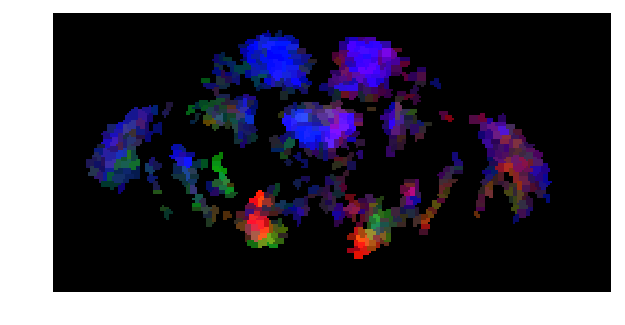

In [152]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(to_plot)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [102]:
scores - scores_ypos_unique

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [103]:
len(scores)

2000

In [104]:
len(scores_ypos_unique)

2000

In [50]:
t0 = time.time()
model = RidgeCV().fit(X,Y)
print(time.time()-t0)

0.008351802825927734


In [51]:
np.sqrt(model.score(X,Y))

0.14594154473853868

In [52]:
model.coef_

array([4.82154344, 0.88425988])

In [13]:
Y.shape

(33840,)